In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

from lampy import data
from lampy import metrics
from lampy.lstm import LSTM

In [2]:
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
data_file = 'data/636f6a2e-3a48-4801-afce-05c864adc60e-lampy_2019.csv'
sid = 'y7e4onsytkb3ydonflz5kcbcigkh5ulo'
target = 'pm10'
attributes = [target, 'o3', 'pm2p5', 'no2', 'so2']

df = data.read_2018_data(data_file).loc[sid, attributes]
resampled_df = data.resample_data(df, period='15T')
X, y = data.create_dataset(resampled_df)
X_tr, X_val, y_tr, y_val = data.train_validation_split(X, y)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_tr_scaled = X_scaler.fit_transform(X_tr)
X_val_scaled = X_scaler.transform(X_val)

y_tr_scaled = y_scaler.fit_transform(y_tr)
y_val_scaled = y_scaler.transform(y_val)

Text(0.5, 1.0, 'validation set')

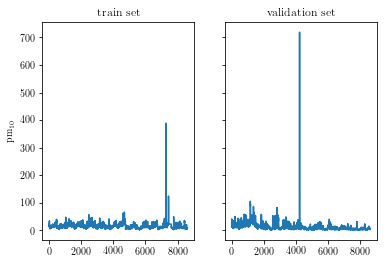

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(y_tr)
ax1.set_ylabel('$\mathrm{pm}_{10}$')
ax1.set_title('train set')
ax2.plot(y_val)
ax2.set_title('validation set')

## Baseline

In [5]:
y_pred = X_val[:, :1]
baseline_rmse = metrics.rmse(y_val, y_pred)
print('baseline RMSE:', baseline_rmse)

baseline RMSE: 8.279020575239366


In [6]:
y_pred = X_tr[:, :1]
baseline_tr_rmse = metrics.rmse(y_tr, y_pred)
print('baseline train RMSE:', baseline_tr_rmse)

baseline train RMSE: 3.6933743519047977


## Lineární regrese

### Metoda nejmenších čtverců

In [7]:
linear = linear_model.LinearRegression()
linear.fit(X_tr, y_tr)

y_pred = linear.predict(X_val)

linear_rmse = metrics.rmse(y_val, y_pred)
print('linear RMSE:', linear_rmse)

print('coefs:', linear.coef_)

linear RMSE: 8.145235410655742
coefs: [[ 0.94737406 -0.01311821  0.01457445  0.01365614  0.00155432]]


In [8]:
y_pred = linear.predict(X_tr)
linear_tr_rmse = metrics.rmse(y_tr, y_pred)
print('linear train RMSE:', linear_tr_rmse)

linear train RMSE: 3.640641688055436


### Lasso

In [9]:
n_alphas = 23
alphas = np.logspace(-10, 1, n_alphas)
lasso_stats = pd.DataFrame(index=alphas, columns=['RMSE', 'coefs'])

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_tr_scaled, y_tr_scaled)

    y_pred_scaled = lasso.predict(X_val_scaled)
    
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    lasso_rmse = metrics.rmse(y_val, y_pred)
    lasso_stats.loc[alpha] = (lasso_rmse, lasso.coef_)

lasso_stats

,RMSE,coefs
1.000000e-10,8.14524,"[0.9473701430589427, -0.01669781664111607, 0.0..."
3.162278e-10,8.14524,"[0.9473701444897213, -0.016697816617726458, 0...."
1.000000e-09,8.14524,"[0.9473701488315144, -0.016697816520755065, 0...."
3.162278e-09,8.14524,"[0.9473701620053735, -0.016697816144084023, 0...."
1.000000e-08,8.14524,"[0.9473702019720326, -0.016697814739778362, 0...."
3.162278e-08,8.14524,"[0.9473703860114054, -0.01669781755914869, 0.0..."
1.000000e-07,8.14524,"[0.9473708819102609, -0.016697815634359722, 0...."
3.162278e-07,8.14524,"[0.9473723859801216, -0.016697801475709775, 0...."
1.000000e-06,8.14524,"[0.9473769397723498, -0.016697731202580324, 0...."
3.162278e-06,8.14526,"[0.9473906524089973, -0.016697422376910267, 0...."


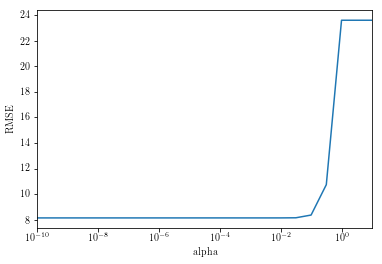

In [10]:
ax = plt.axes()
lasso_stats['RMSE'].plot(ax=ax)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE');

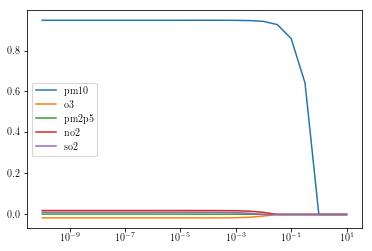

In [11]:
coefs = []
for coef in lasso_stats['coefs']:
    coefs.append(list(coef))
coefs = np.array(coefs)

ax = plt.axes()
for attribute, coef in zip(attributes, coefs.T):
    ax.plot(alphas, coef, label=attribute)
    ax.set_xscale('log')
ax.legend();

## LSTM

In [12]:
lstm = LSTM(input_size=5, hidden_size=64, output_size=1)
lstm_stats = lstm.train(X_tr_scaled, y_tr_scaled, X_val_scaled, y_val_scaled,
                        n_epochs=50, seq_len=100)

epoch: 1 train loss: 0.5887650150548422 validation loss: 2.3850322075208914
epoch: 2 train loss: 0.47646359448092523 validation loss: 2.235391459203807
epoch: 3 train loss: 0.4023603751779779 validation loss: 2.1308289991005105
epoch: 4 train loss: 0.3485854470493727 validation loss: 2.0495557864728413
epoch: 5 train loss: 0.30819135976366663 validation loss: 1.9724359113857939
epoch: 6 train loss: 0.2819280421015831 validation loss: 1.8974319217154132
epoch: 7 train loss: 0.26233309543728334 validation loss: 1.8312972413242805
epoch: 8 train loss: 0.2460427327759378 validation loss: 1.7918871186237812
epoch: 9 train loss: 0.23283313274550027 validation loss: 1.7243123032367107
epoch: 10 train loss: 0.22058816622041091 validation loss: 1.6918912443056522
epoch: 11 train loss: 0.20929788471768743 validation loss: 1.635221943549791
epoch: 12 train loss: 0.1990699731622127 validation loss: 1.6179832805608751
epoch: 13 train loss: 0.19113662487819674 validation loss: 1.558513049849118
epoc

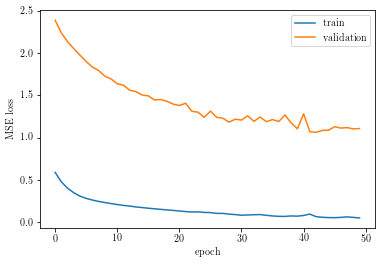

In [13]:
ax = plt.axes()
ax.plot(lstm_stats['tr_losses'], label='train')
ax.plot(lstm_stats['val_losses'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.legend();

In [14]:
y_pred_scaled = lstm.predict(X_val_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
lstm_rmse = metrics.rmse(y_val, y_pred)
lstm_rmse

13.412302569274095

In [15]:
y_pred_scaled = lstm.predict(X_tr_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
lstm_tr_rmse = metrics.rmse(y_tr, y_pred)
lstm_tr_rmse

2.822913414520962

## Results

In [16]:
# lasso show that other parameters are linearly unimportant
print('baseline RMSE:', baseline_rmse)
print('linear RMSE:  ', linear_rmse)
print('LSTM RMSE:    ', lstm_rmse)

baseline RMSE: 8.279020575239366
linear RMSE:   8.145235410655742
LSTM RMSE:     13.412302569274095


In [17]:
print('baseline train RMSE:', baseline_tr_rmse)
print('linear train RMSE:  ', linear_tr_rmse)
print('LSTM train RMSE:    ', lstm_tr_rmse)

baseline train RMSE: 3.6933743519047977
linear train RMSE:   3.640641688055436
LSTM train RMSE:     2.822913414520962
